In [1]:
import os, shutil, random
from types import SimpleNamespace
from pathlib import Path
from kaggle import api
import zipfile
import torch
import wandb
import torchvision
import torchvision.transforms as T
from PIL import Image
from fastdownload import FastDownload
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

In [2]:
def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [3]:
def untar_data(url, force_download=False, base='./datasets'):
    d = FastDownload(base=base)
    return d.get(url, force=force_download, extract_key='data')

In [4]:
def get_kaggle_dataset(dataset_path, # Local path to download dataset to
                dataset_slug, # Dataset slug (ie "zillow/zecon")
                unzip=True, # Should it unzip after downloading?
                force=False # Should it overwrite or error if dataset_path exists?
               ):
    '''Downloads an existing dataset and metadata from kaggle'''
    if not force and Path(dataset_path).exists():
        return Path(dataset_path)
    api.dataset_metadata(dataset_slug, str(dataset_path))
    api.dataset_download_files(dataset_slug, str(dataset_path))
    if unzip:
        zipped_file = Path(dataset_path)/f"{dataset_slug.split('/')[-1]}.zip"
        import zipfile
        with zipfile.ZipFile(zipped_file, 'r') as zip_ref:
            zip_ref.extractall(Path(dataset_path))
        zipped_file.unlink()

In [5]:
cifar_labels = "airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck".split(",")

In [6]:
def get_cifar(cifar100=False, img_size=64):
    "Download and extract CIFAR"
    cifar10_url = 'https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz'
    cifar100_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz'
    if img_size==32:
        return untar_data(cifar100_url if cifar100 else cifar10_url)
    else:
        get_kaggle_dataset("datasets/cifar10_64", "joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution")
        return Path("datasets/cifar10_64/cifar10-64")

In [7]:
path = get_cifar()

In [8]:
path

Path('datasets/cifar10_64/cifar10-64')

In [9]:
path.ls()

(#2) [Path('datasets/cifar10_64/cifar10-64/test'),Path('datasets/cifar10_64/cifar10-64/train')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


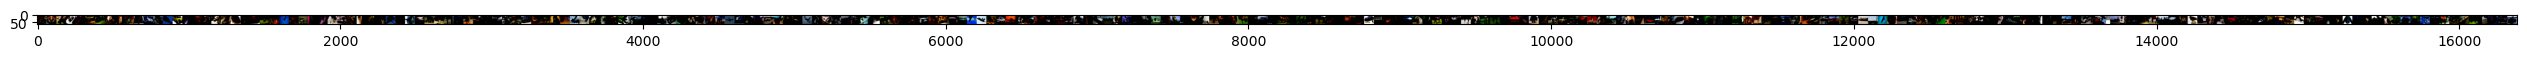

In [51]:
plot_images(x)

In [10]:
at = wandb.Artifact("CIFAR10_64", type="dataset", 
                    description="The CIFAR10 datasets scaled to 64 pixels",  
                    metadata={"img_size":64, "url": "kaggle.com/joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution",
                              "labels":cifar_labels})

In [11]:
at.add_dir("datasets/cifar10_64/cifar10-64/")

wandb: Adding directory to artifact (./datasets/cifar10_64/cifar10-64)... Done. 40.5s


In [12]:
with wandb.init(project="train_sd", job_type="log_dataset"):
    wandb.log_artifact(at)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter-ukb12/.netrc


In [13]:
def get_cifar_data(dataset_path, img_size=64, batch_size=8, train_folder="train", val_folder="test", slice_size=-1, num_workers=4):
    train_transforms = torchvision.transforms.Compose([
        T.Resize(img_size + int(.25*img_size)),  # img_size + 1/4 *img_size
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    val_transforms = torchvision.transforms.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, train_folder), transform=train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(os.path.join(dataset_path, val_folder), transform=val_transforms)
    
    if slice_size>1:
        train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset), slice_size))
        val_dataset = torch.utils.data.Subset(val_dataset, indices=range(0, len(val_dataset), slice_size))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataset = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_dataloader, val_dataset

In [14]:
train_dl, val_dl = get_cifar_data(path, batch_size=256, slice_size=100)

In [15]:
train_batch = next(iter(train_dl))

In [16]:
x, y = train_batch

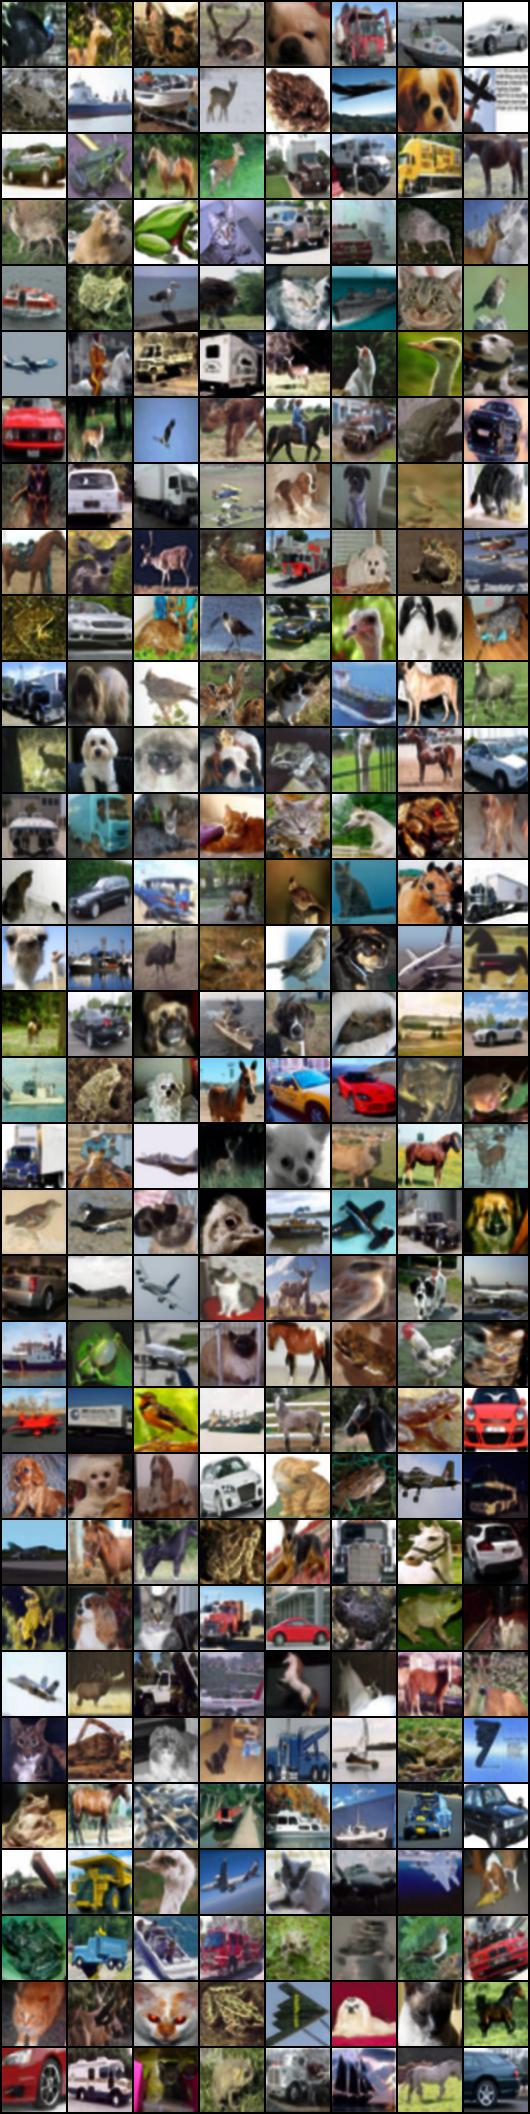

In [17]:
wandb.Image(x).image

In [18]:
table = wandb.Table(columns=["image", "label_id", "label", "split"])

In [19]:
for img, label in iter(train_dl.dataset):
    table.add_data(wandb.Image(img), label, cifar_labels[label], "train")

In [20]:
for img, label in iter(val_dl.dataset):
    table.add_data(wandb.Image(img), label, cifar_labels[label], "valid")

In [21]:
with wandb.init(project="train_sd", group="cifar10", job_type="dataset_viz"):
    wandb.use_artifact('capecape/train_sd/CIFAR10_64:v0', type='dataset')
    wandb.log({"cifar_viz":table})

wandb: Currently logged in as: sakevich2001 (imics). Use `wandb login --relogin` to force relogin


In [22]:
def get_alphabet_dl(batch_size=8, num_workers=4, slice_size=-1):
    get_kaggle_dataset("datasets/alphabet", "thomasqazwsxedc/alphabet-characters-fonts-dataset")
    train_transforms = T.Compose([
        T.Grayscale(),
        T.ToTensor(),])
    train_dataset = torchvision.datasets.ImageFolder(root="./datasets/alphabet/Images/Images/", transform=train_transforms)
    if slice_size>1:
        train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset), slice_size))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return train_dataloader, None

In [23]:
alphabet_labels = "A B C D E F G H I J K L M N O P Q R S T U V W X Y Z".split(" ")

In [24]:
at = wandb.Artifact("Alphabet", type="dataset", 
                    description="A collection of 15k fonts in image format",  
                    metadata={"img_size":64, "url": "kaggle.com/thomasqazwsxedc/alphabet-characters-fonts-dataset",
                              "labels":alphabet_labels})

## didn't log, it's very big (300k files).

In [25]:

train_dl, _ = get_alphabet_dl(batch_size=128, slice_size=100)

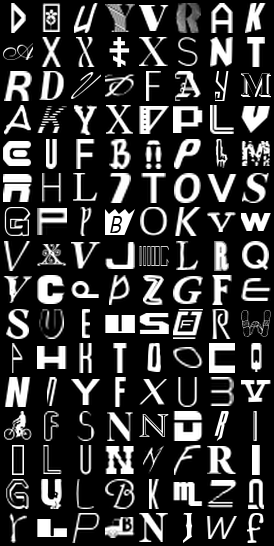

In [26]:
wandb.Image(next(iter(train_dl))[0]).image

In [27]:
table = wandb.Table(columns=["image", "label_id", "label", "split"])

In [28]:
for img, label in iter(train_dl.dataset):
    table.add_data(wandb.Image(img), label, alphabet_labels[label], "train")

In [29]:
with wandb.init(project="train_sd", group="alphabet", job_type="dataset_viz"):
    wandb.log({"alphabet_viz":table})

In [2]:
import torchvision

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./datasets/',
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 20631458.85it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57437503.00it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 8035698.06it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9265821.39it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



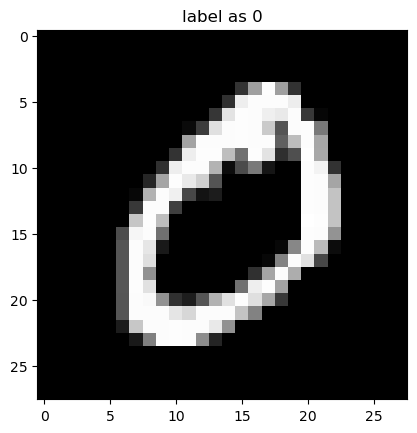

In [5]:
import matplotlib.pyplot as plt 
img = train_dataset.data[1]
plt.title(f'label as {train_dataset.targets[1]}')
plt.imshow(img, cmap='gray')